In [32]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

In [33]:
import pandas as pd
import numpy as np

In [34]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [35]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


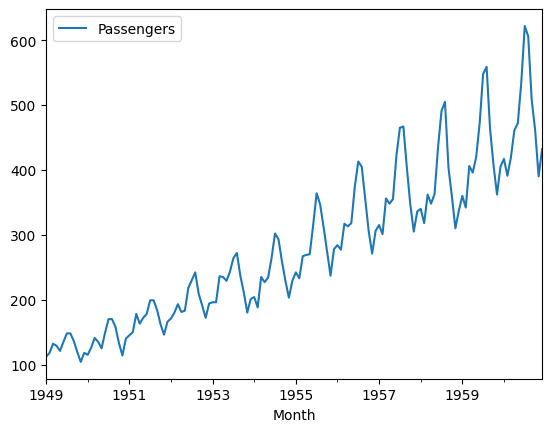

In [36]:
df.plot();

In [37]:
alpha = 0.2

In [38]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [39]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [40]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

<Axes: xlabel='Month'>

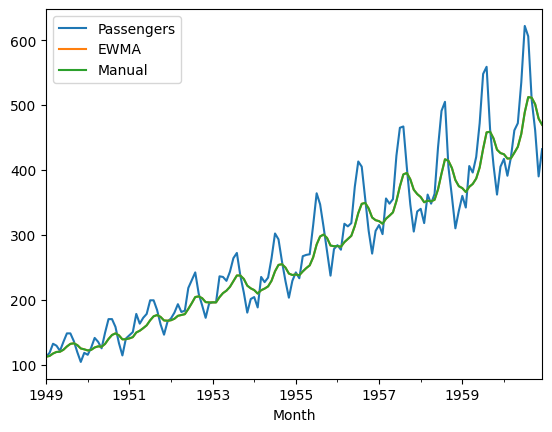

In [41]:
df.plot()

In [42]:
df.drop('Manual', axis=1, inplace=True)

In [43]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [44]:
ses = SimpleExpSmoothing(df['Passengers'])

/Users/tantravahivenkataaditya/opt/anaconda3/envs/pyfineng/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [46]:
df.index.freq = 'MS'

In [47]:
ses = SimpleExpSmoothing(df['Passengers'])

In [48]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [49]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [50]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [51]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

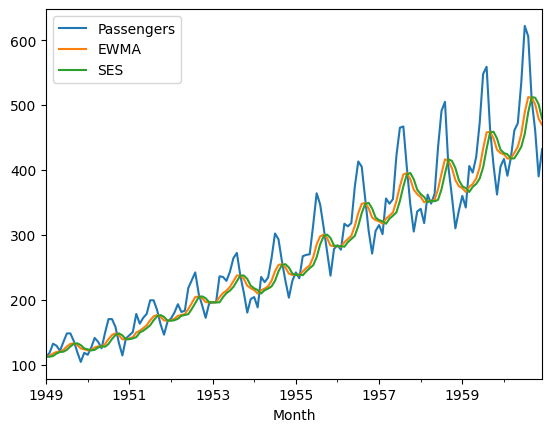

In [52]:
df.plot()

In [53]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [54]:
df['SES-1'] = df['SES'].shift(-1)

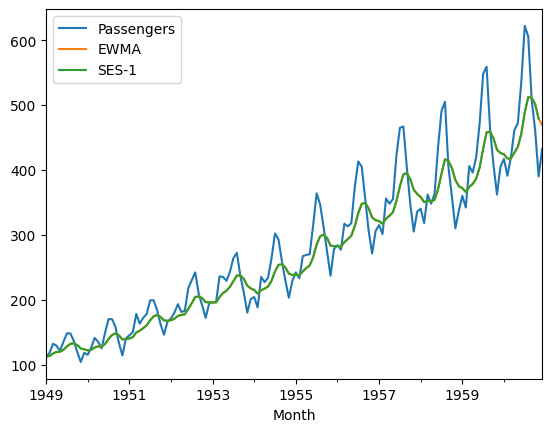

In [55]:
### Does not make sense
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [56]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]


In [57]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

In [58]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

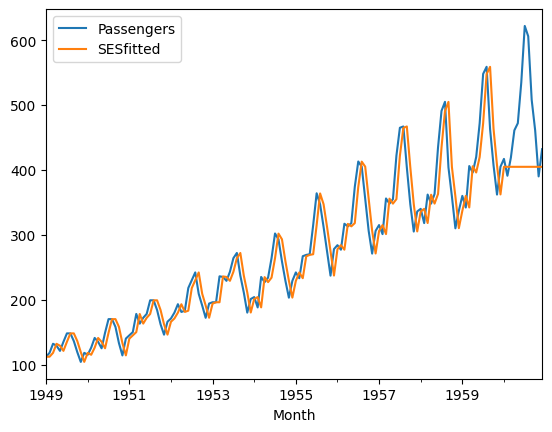

In [59]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [60]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [62]:
## Holt's Linear Trend

In [63]:
from statsmodels.tsa.holtwinters import Holt

In [64]:
holt = Holt(train['Passengers'])

In [65]:
res_h = holt.fit()

In [68]:
res_h.params

{'smoothing_level': 0.9950221732119497,
 'smoothing_trend': 0.00451213941180862,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 111.94722153527978,
 'initial_trend': 1.586305070628141,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [66]:
df['Holt'] = res_h.fittedvalues

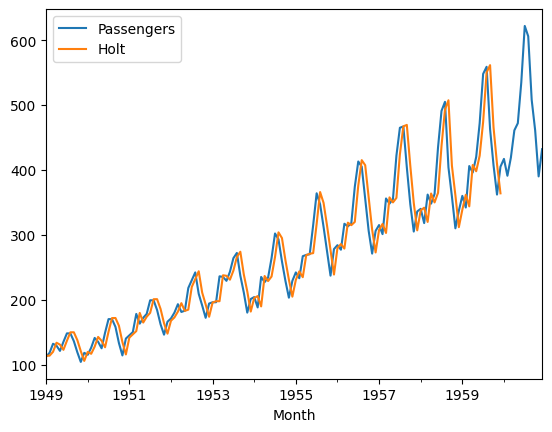

In [67]:
df[['Passengers', 'Holt']].plot();

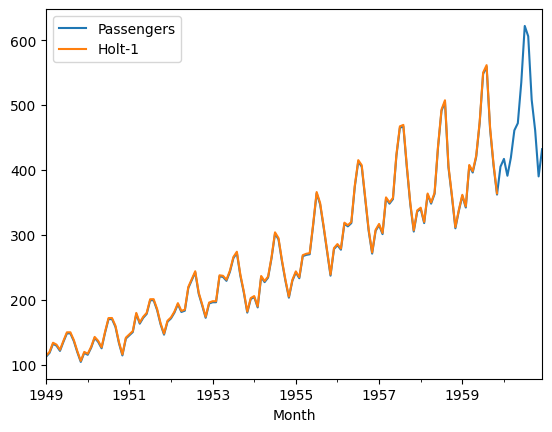

In [69]:
### No! never do this
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [70]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [71]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

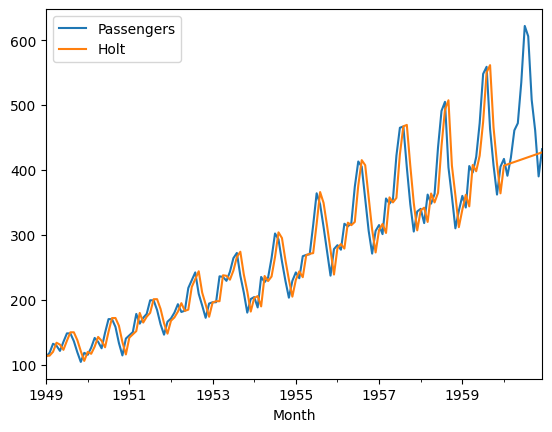

In [72]:
df[['Passengers', 'Holt']].plot();

In [73]:
### Holt-Winters

In [74]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing